In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [45]:
## csv 파일 불러오기
abandoned = pd.read_csv('유기동물보호현황.csv', encoding='cp949')
abandoned[:2]

,시군명,접수일자,발견장소,상태,공고고유번호,공고시작일자,공고종료일자,품종,색상,나이,...,보호소전화번호,보호소도로명주소,보호소지번주소,보호소우편번호,관할기관,특이사항,이미지경로,썸네일이미지경로,WGS84위도,WGS84경도
0,오산시,20230514,성호대로141,보호중,경기-오산-2023-00116,20230514,20230524,[고양이] 한국 고양이,치즈색,2023(60일미만)(년생),...,031-372-9325,경기도 오산시 성호대로 36,경기도 오산시 오산동 609-55번지,18130,경기도 오산시,NaN,http://www.animal.go.kr/files/shelter/2023/05/...,http://www.animal.go.kr/files/shelter/2023/05/...,37.149089,127.065203
1,오산시,20230514,성호대로141,보호중,경기-오산-2023-00115,20230514,20230524,[고양이] 한국 고양이,치지색,2023(60일미만)(년생),...,031-372-9325,경기도 오산시 성호대로 36,경기도 오산시 오산동 609-55번지,18130,경기도 오산시,NaN,http://www.animal.go.kr/files/shelter/2023/05/...,http://www.animal.go.kr/files/shelter/2023/05/...,37.149089,127.065203


In [11]:
## 파일 정보 확인
abandoned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   시군명     9127 non-null   object        
 1   접수일자    9127 non-null   datetime64[ns]
 2   상태      9127 non-null   object        
 3   품종      9127 non-null   object        
 4   나이      9127 non-null   int64         
 5   체중      9127 non-null   float64       
 6   성별      9127 non-null   object        
 7   중성화여부   9127 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 570.6+ KB


In [47]:
## 컬럼 정리
abandoned.drop(columns=['발견장소', '공고고유번호', '공고시작일자', '공고종료일자'
                       , '특징', '보호소명', '보호소전화번호', '보호소도로명주소', '보호소지번주소', '보호소우편번호'
                       , '이미지경로', '썸네일이미지경로', 'WGS84위도', 'WGS84경도', '특이사항', '관할기관'], inplace=True)

In [42]:
## 잘못 표시된 값 수정 : U -> Q
abandoned.loc[abandoned.중성화여부 == 'U', '중성화여부'] = 'Q'
abandoned.체중 = abandoned.체중.str.replace('(Kg)', '').str.replace(',', '.').str.replace('..', '.').str.replace("\'", "")

# abandoned[abandoned['체중'] == '.5.9']
# abandoned[abandoned['체중'] == '6.3.']

abandoned.loc[6735, '체중'] = '5.9'
abandoned.loc[7146, '체중'] = '6.3'

In [85]:
## 체중 컬럼 dtype 변경 : object -> float
abandoned.체중 = abandoned.체중.apply(float)

In [13]:
## 접수일자 컬럼 dtype 변경 : int -> str -> datetime
abandoned.접수일자 = abandoned.접수일자.astype('str')
abandoned.접수일자 = pd.to_datetime(abandoned['접수일자'])

## datetime format 변경
abandoned.접수일자 = abandoned.접수일자.dt.strftime('%Y-%m')

In [71]:
## 작년기준 60일 미만 유기동물들의 나이는 2022년생으로 수정
abandoned.loc[abandoned.나이 == '2022(60일미만)(년생)', '나이'] = '2022(년생)'

## 나이컬럼 수정 및 dtype 변경 : n(년생) -> (2023 - n + 1)살, int
## 60일 미만 -> 0살
abandoned.loc[abandoned.나이 == '2023(년생)(60일미만)', '나이'] = 0
abandoned.나이 = abandoned.나이.str.replace('(년생)', '')
abandoned.나이 = abandoned.나이.astype('int16')
abandoned.나이 = 2023 - abandoned.나이 + 1

In [97]:
## 품종 컬럼값 공백 제거
abandoned.품종 = abandoned.품종.str.replace(' ', '')

In [63]:
## 컬럼 추가
abandoned['품종상세'] = abandoned.품종

abandoned.loc[abandoned.품종상세.str.contains(r'\[고양이\]'), '품종상세'] = '고양이'
abandoned.loc[abandoned.품종상세.str.contains(r'\[개\]'), '품종상세'] = '개'
abandoned.loc[abandoned.품종상세.str.contains(r'\[기타축종\]'), '품종상세'] = '기타축종'

In [70]:
## 컬럼순서 조정
abandoned = abandoned[['시군명', '접수일자', '상태', '품종상세', '품종', '나이', '체중', '성별', '중성화여부']]

In [71]:
abandoned.rename(columns={'품종': '품종상세', '품종상세': '품종'}, inplace=True)

In [16]:
## csv 파일 저장
abandoned.to_csv('abandoned.csv', index=False, encoding='UTF-8')

In [46]:
## 품종 분류 : 고양이
abandoned_cat = abandoned[abandoned.품종.str.contains(r'\[고양이\]')]

,시군명,접수일자,상태,품종,나이,체중,성별,중성화여부
0,오산시,2023-05,보호중,[고양이]한국고양이,0,0.11,Q,N
1,오산시,2023-05,보호중,[고양이]한국고양이,0,0.10,Q,N


In [47]:
## 품종 분류 : 개
abandoned_dog = abandoned[abandoned.품종.str.contains(r'\[개\]')]

,시군명,접수일자,상태,품종,나이,체중,성별,중성화여부
2,남양주시,2023-05,보호중,[개]셰퍼드,3,24.0,F,N
3,남양주시,2023-05,보호중,[개]셰퍼드,3,27.0,M,N


In [48]:
## 품종 분류 : 기타축종
abandoned_other = abandoned[abandoned.품종.str.contains(r'\[기타축종\]')]

,시군명,접수일자,상태,품종,나이,체중,성별,중성화여부
81,성남시,2023-05,종료(자연사),[기타축종]햄스터,2,0.01,Q,N
220,고양시,2023-05,보호중,[기타축종]앵무새,2,0.03,Q,Q


In [102]:
abandoned.to_csv('abandoned.csv', index=False, encoding='utf-8')

가설 3개이상
1. 유기동물의 수는 꾸준히 증가했을 것이다
1. 유기동물의 종류는 개가 가장 많을 것이다
1. 개의 품종은 믹스견이 가장 많을 것이다
1. 나이가 어린(1살 이하) 동물들의 수가 많을 것이다

자료기간 : 2022-11-15 ~ 2023-05-14

 「동물보호법」 제40조에 따른 공고가 있는 날부터 10일이 지나도 소유자등을 알 수 없는 경우에는
「유실물법」 제12조 및 「민법」 제253조에도 불구하고 해당 시ㆍ도지사 또는 시장ㆍ군수ㆍ구청장이 그 동물의 소유권을 취득하게 됩니다.

안락사에 관한 공식적인 가이드라인은 없는 상태. 개별 수의사에게 맡겨진 셈임

In [3]:
## 한글 설정
plt.rc('font', family='D2coding')

NameError: name 'plt' is not defined

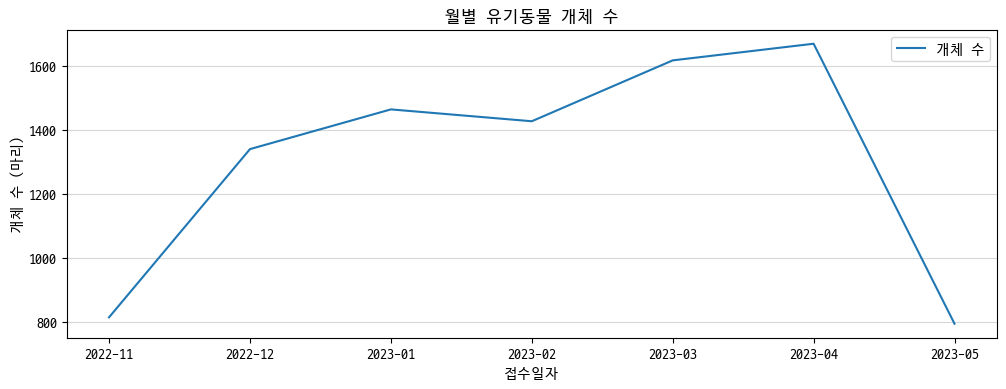

In [224]:
## [가설 1] 유기동물의 수는 꾸준히 증가했을 것이다
## 5월 14일까지의 데이터라 5월 데이터가 부족

abandoned.groupby('접수일자').size().plot(
    kind='line',
    title='월별 유기동물 개체 수',
    rot=0,
    figsize=(12, 4),
    label='개체 수',
)
plt.grid(axis='y', alpha=0.5)
plt.ylabel('개체 수 (마리)')
plt.legend()
plt.show()

<Axes: title={'center': '유기동물 품종 비율'}>

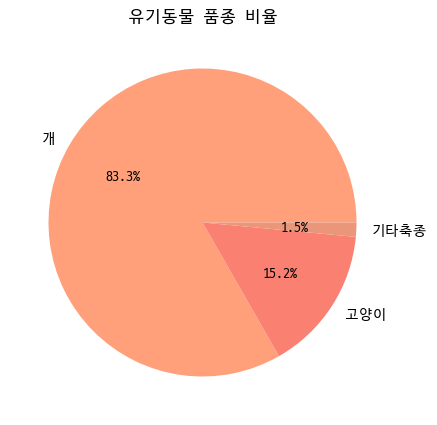

In [213]:
## [가설 2] 유기동물의 종류는 개가 가장 많을 것이다  -> 개, 고양이, 기타축종
abandoned.groupby('품종').size().sort_values(ascending=False).plot(
    kind='pie',
    title='유기동물 품종 비율',
    figsize=(5, 5),
    autopct='%.1f%%',
    colors=['#FFA07A', '#FA8072', '#E9967A'],
    #colormap='BuPu',
)

Text(0, 0.5, '개체 수 (마리)')

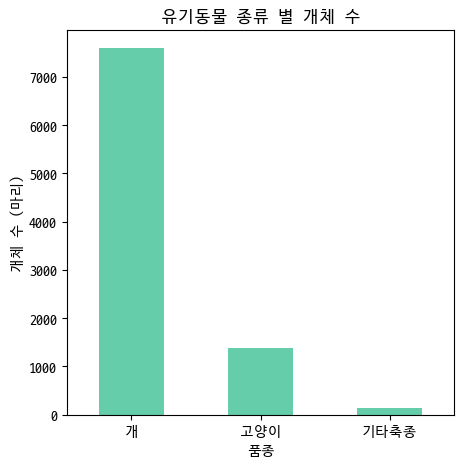

In [223]:
abandoned.groupby('품종').size().sort_values(ascending=False).plot(
    kind='bar',
    title='유기동물 종류 별 개체 수',
    rot=0,
    figsize=(5, 5),
    width=0.5,
    color='#66CDAA',
)
plt.ylabel('개체 수 (마리)')

<Axes: title={'center': '유기견 상위 10개 품종'}>

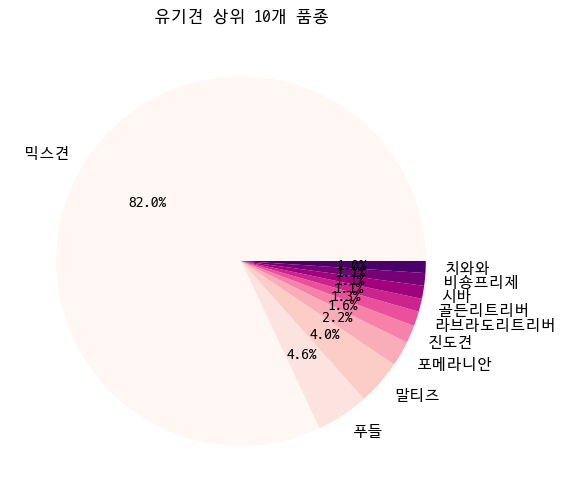

In [158]:
## [가설 3] 개의 품종은 믹스견이 가장 많을 것이다
## 방법 생각좀 해보자
abandoned[abandoned.품종 == '개'].groupby('품종상세').size().sort_values(ascending=False)[:10].plot(
    kind='pie',
    title='유기견 상위 10개 품종',
    autopct='%.1f%%',
    figsize=(6, 6),
    fontsize=11,
    colormap='RdPu'
)

In [2]:
## [가설 4] 나이가 어린(1살 이하) 동물들의 수가 많을 것이다
abandoned.groupby('나이').size().plot(
    figsize=(14 ,5),
    xticks=(range(0, len(abandoned.groupby('나이').size()))),
    label='개체수',
    title='유기동물 나이 별 개체수',
    
)
plt.ylabel('개체 수 (마리)')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

NameError: name 'abandoned' is not defined